In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from functions import draw_annotations
import geomappy as mp
from geomappy import basemap, plot_shapes, plot_classified_shapes
from geomappy.colors import cmap_discrete, legend_patches
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib

dpi = 300
cmap = 'tab10'
fontsize = 12
matplotlib.rcParams.update({'font.size': fontsize})

## Loading the data

In [2]:
df_flopros = gpd.read_file("data/plastic_mobilisation/flopros.shp")
df_flopros_nans = df_flopros.loc[df_flopros.jump.isna(), :]
df_flopros = df_flopros.loc[~pd.isna(df_flopros.jump), :]
df_flopros = df_flopros.loc[df_flopros.ISO != "XCA", :]

flopros_rp = pd.read_excel("data/Flood_defences/Flopros_shp/FLOPROS_geogunit_107.xlsx", index_col=0)
# Fill in the gaps with 2
flopros_rp.loc[flopros_rp.Riverine.isna(), "Riverine"] = 2
flopros_rp.loc[:, "RP"] = flopros_rp.Riverine

# Add flood protection to the PMP data
df_flopros = df_flopros.merge(flopros_rp.RP, left_on="FID_Aque", right_index=True)
# Add a jump column between the RP10 and RP1
df_flopros.loc[:, "jump"] = df_flopros.loc[:, "e_10"] / df_flopros.loc[:, "e_1"]

for rp in [1, 10, 20, 50, 100, 200, 500]:
    df_flopros.loc[:, f"e_{rp}_protected"] = df_flopros.apply(
        lambda x: x.e_1 if x.RP > rp else x[f'e_{rp}'], axis=1
    )

# EAM
rp = [1, 1, 10, 20, 50, 100, 200, 500, 500]
p = [1 / i for i in rp]
p[1] = 0.5
p[-1] = 0
df_flopros.loc[:, "EAM"] = np.trapz(y=df_flopros.loc[:, [f'e_{x}' for x in rp[::-1]]], x=p[::-1])
df_flopros.loc[:, "EAM_protected"] = np.trapz(y=df_flopros.loc[:, [f'e_{x}_protected' for x in rp[::-1]]], x=p[::-1])

# Group by country, calculate RP1 in Mt and create the jump
df_countries = df_flopros.groupby("ISO").sum().sort_values("Shape_Area", ascending=False)
df_countries.loc[:, "e_1_Mt"] = df_countries.loc[:, "e_1"] / 1000000000
df_countries.loc[:, "jump"] = df_countries.loc[:, "e_10"] / df_countries.loc[:, "e_1"]

# Group the whole world
df_world = df_flopros.sum(axis=0)
natural_idx = [f"e_{x}" for x in (1, 10, 20, 50, 100, 200, 500)]
protected_idx = [f"e_{x}_protected" for x in (1, 10, 20, 50, 100, 200, 500)]
df_world[natural_idx + ['EAM']] = df_world[natural_idx + ['EAM']] / 1000000000
df_world[protected_idx + ['EAM_protected']] = df_world[protected_idx + ["EAM_protected"]] / 1000000000

df_ISO_continents = pd.read_csv("data/ISO_continents/country_and_continent_codes_list.csv")[:-4]
df_countries = df_countries.merge(df_ISO_continents, right_on="Three_Letter_Country_Code", left_index=True, how='left')
CONTINENTS = ["Europe", "Asia", "North America", "South America", "Africa", "Oceania"]
df_countries.loc[:, 'colors'] = df_countries.Continent_Name.apply(lambda x: CONTINENTS.index(x))

df_countries = df_countries.loc[df_countries.area_10 > df_countries.area_10.quantile(0.05), :]

In [3]:
df_basins_start = gpd.read_file("data/plastic_mobilisation/basins.shp")

## Figures

### Scatterplot countries

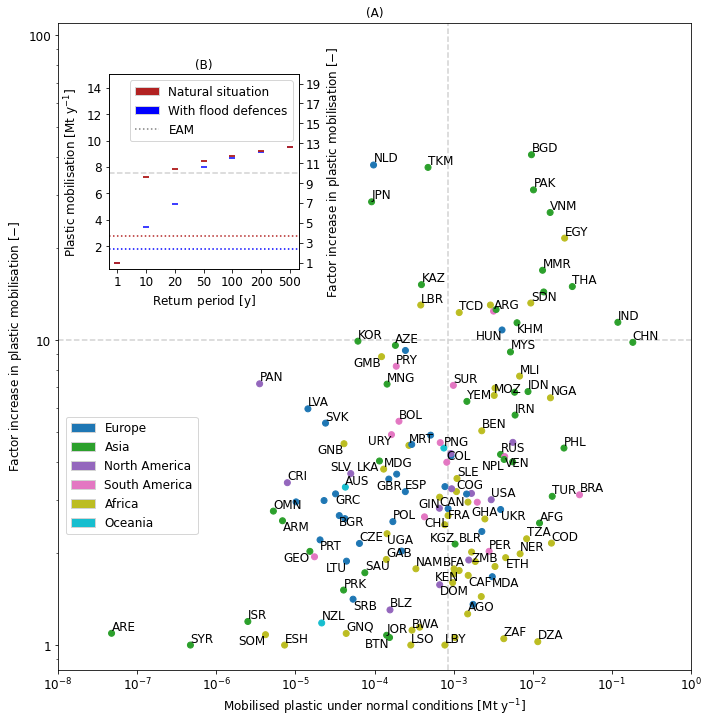

In [4]:
f, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df_countries.e_1_Mt, df_countries.jump, c=df_countries.colors, cmap=cmap)

ax.loglog()
ax.axhline(10, linestyle="--", alpha=1, color='lightgrey', zorder=-1)
ax.axvline(df_countries.e_1.median()/1000000000, linestyle="--", alpha=1, color='lightgrey', zorder=-1)
ax.set_ylabel(r"Factor increase in plastic mobilisation $\rm{[-]}$", fontsize=fontsize)
ax.set_xlabel(r"Mobilised plastic under normal conditions $\rm{[Mt\ y^{-1}]}$", fontsize=fontsize)
ax.set_xlim(10 ** (1 - 9), 10 ** (9 - 9))
ax.set_ylim(None, 110)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
draw_annotations(list(df_countries.Three_Letter_Country_Code),
                 list(df_countries['e_1_Mt']),
                 list(df_countries.jump),
                 overlapping_pixels=1, fontsize=fontsize)

x = list(range(7))
x_str = [str(x) for x in (1, 10, 20, 50, 100, 200, 500)]

axin = ax.inset_axes([0.08, 0.62, 0.30, 0.30])
axin.scatter(x=x, y=df_world[protected_idx], marker="_", color='Blue')
axin.scatter(x=x, y=df_world[natural_idx], marker="_", color='Firebrick')
axin.set_ylim(None, 15)
axin.set_title("(B)", fontsize=fontsize)
axin.axhline(df_world.e_1 * 10, linestyle="--", alpha=1, color='lightgrey', zorder=-1)
axin.axhline(df_world.EAM, color="Firebrick", linestyle=":")
axin.axhline(df_world.EAM_protected, color="Blue", linestyle=":")
axin_copy = axin.twinx()
axin_copy.scatter(x=x, y=df_world[natural_idx] / df_world[natural_idx][0], marker="_", color='Firebrick')
axin_copy.set_ylim(axin.get_ybound()[0] / df_world[protected_idx][0],
                   axin.get_ybound()[1] / df_world[protected_idx][0])
axin_copy.set_yticks(np.arange(1, 20, 2))

axin.set_xticks(x)
axin.set_xticklabels(x_str)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
axin.tick_params(axis='both', which='major', labelsize=fontsize)
axin_copy.tick_params(axis='both', which='major', labelsize=fontsize)
axin.set_xlabel(r'Return period $\rm{[y]}$', fontsize=fontsize)
axin.set_ylabel(r"Plastic mobilisation $\rm{[Mt\ y^{-1}]}$", fontsize=fontsize)
axin_copy.set_ylabel(r"Factor increase in plastic mobilisation $\rm{[-]}$", fontsize=fontsize)
axin.legend(handles=legend_patches(colors=["Firebrick", "Blue"], labels=["Natural situation", "With flood defences"]) +
                    legend_patches(colors=["grey"], labels=["EAM"], type=":"), loc=1)

ax.legend(handles=legend_patches(colors=cmap_discrete(cmap, n=len(CONTINENTS), return_type='list'), labels=CONTINENTS),
          prop={'size': fontsize}, bbox_to_anchor=(0.23, 0.4))
ax.set_yticks([1, 10, 100])
ax.set_yticklabels(["1", "10", "100"])
ax.set_xticks(np.logspace(-8, 0, num=9))
ax.set_title("(A)", fontsize=fontsize)

plt.savefig('figures/draft/country_emissions_and_jump.png', dpi=dpi, bbox_inches='tight')
plt.show()

### Four global subplots

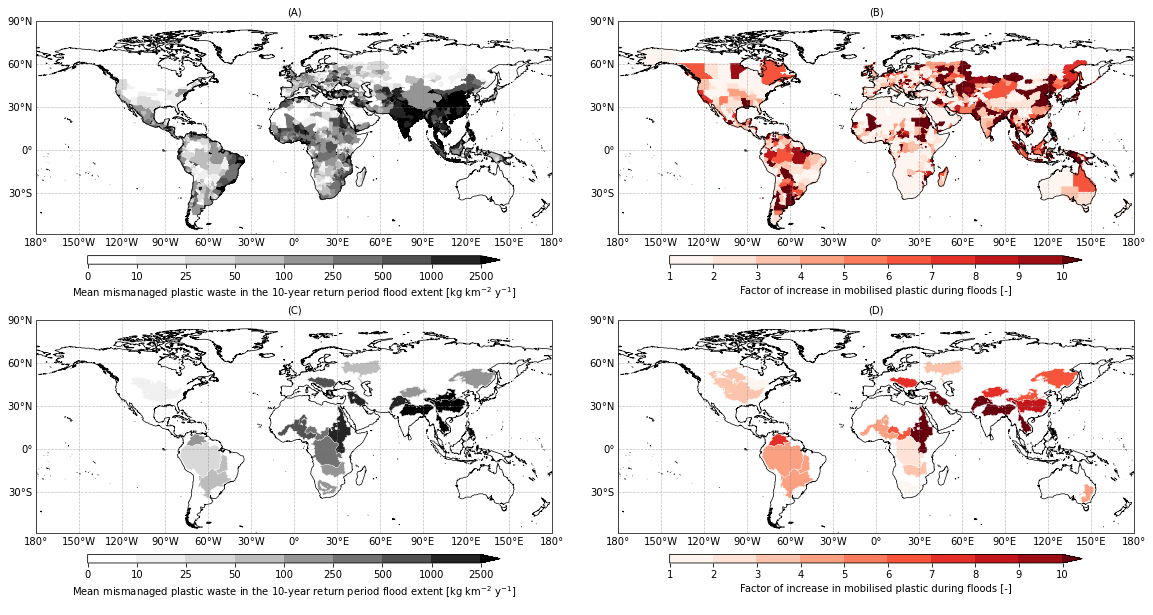

In [6]:
df_basins = df_basins_start.sort_values("AREA_SQKM").tail(25)
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 9))
plt.tight_layout(h_pad=-1.2, w_pad=-2, pad=1.5)
ax = [basemap(y0=-59, linewidth=0.7, ax=cax, resolution='50m') for cax in ax.flatten()]

plot_shapes(df=df_flopros, values=df_flopros.e_10 / df_flopros.area_10,
            bins=[0, 10, 25, 50, 100, 250, 500, 1000, 2500],
            cmap="Greys", ax=ax[0], fontsize=10, pad_fraction=2.5, aspect=20,
            legend_kwargs={'position': 'bottom', 'shrink': 0.8,
                           'label': r'Mean mismanaged plastic waste in the 10-year return period flood extent $\rm{[kg\ km^{-2}\ y^{-1}]}$'})
plot_shapes(df=df_flopros, values='jump', bins=list(range(1, 11)), cmap="Reds", ax=ax[1],
            fontsize=10, pad_fraction=2.5, aspect=20,
            legend_kwargs={'position': 'bottom', 'shrink': 0.8,
                           'label': 'Factor of increase in mobilised plastic during floods [-]'})

plot_shapes(df=df_basins, values=df_basins.e_10 / df_basins.area_10,
            cmap="Greys", ax=ax[2], fontsize=10, linewidth=0.2, edgecolor='white',
            bins=[0, 10, 25, 50, 100, 250, 500, 1000, 2500], pad_fraction=2.5, aspect=20,
            legend_kwargs={'position': 'bottom', 'shrink': 0.8,
                           'label': r'Mean mismanaged plastic waste in the 10-year return period flood extent $\rm{[kg\ km^{-2}\ y^{-1}]}$'})
plot_shapes(df=df_basins, values='jump', bins=list(range(1, 11)), linewidth=0.2, edgecolor='white',
            cmap="Reds", ax=ax[3], fontsize=10, pad_fraction=2.5, aspect=20,
            legend_kwargs={'position': 'bottom', 'shrink': 0.8,
                           'label': 'Factor of increase in mobilised plastic during floods [-]'})

ax[0].set_title("(A)", fontsize=10)
ax[1].set_title("(B)", fontsize=10)
ax[2].set_title("(C)", fontsize=10)
ax[3].set_title("(D)", fontsize=10)
plt.savefig("figures/draft/global_admin_jump_RP10_per_unit_area_including_basins.png", dpi=300,
            bbox_inches='tight')
plt.show()

### Countries scatterplot with and without flood defences

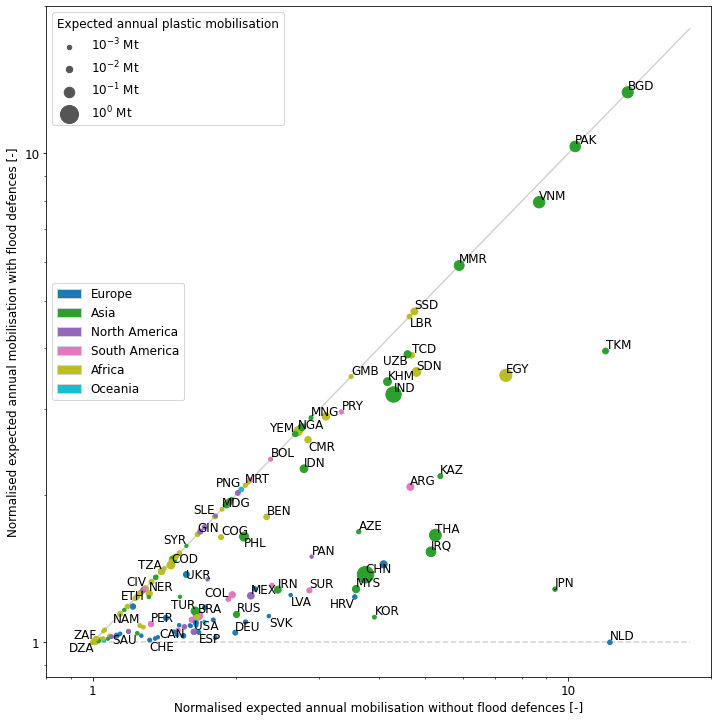

In [7]:
f, ax = plt.subplots(figsize=(10, 10))
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.8, 20)
plt.ylim(0.85, 20)
ax.plot([1, 18], [1, 18], color='lightgrey', zorder=1)
ax.plot([1, 18], [1, 1], linestyle="--", color='lightgrey', zorder=1)
ax.scatter(df_countries.EAM / df_countries.e_1,
           df_countries.EAM_protected / df_countries.e_1_protected,
           c=df_countries.colors,
           cmap=cmap,
           zorder=2,
           s=np.sqrt(df_countries.EAM) / 100 + 10)
draw_annotations(x=list(df_countries.EAM / df_countries.e_1),
                 y=list(df_countries.EAM_protected / df_countries.e_1_protected),
                 t=list(df_countries.Three_Letter_Country_Code),
                 ax=ax, fontsize=fontsize, zorder=3, overlapping_pixels=1)
legend = plt.legend(
    handles=legend_patches(colors=cmap_discrete(cmap, n=len(CONTINENTS), return_type='list'), labels=CONTINENTS),
    prop={'size': fontsize}, loc=6)

l = []
for x in list(range(6, 10)):
    l.append(plt.scatter([], [], marker='o', color='#555555', s=np.sqrt(10 ** x) / 100 + 10, label=x))
legend_2 = ax.legend(l, [r"$10^{-3}$ Mt", "$10^{-2}$ Mt", "$10^{-1}$ Mt", "$10^{0}$ Mt"],
                     title="Expected annual plastic mobilisation", loc=2)
legend_2._legend_box.align = "left"
ax.add_artist(legend)

ax.set_xlabel("Normalised expected annual mobilisation without flood defences [-]")
ax.set_ylabel("Normalised expected annual mobilisation with flood defences [-]")
ax.set_xticks((1, 10))
ax.set_xticklabels(("1", "10"))
ax.set_yticks((1, 10))
ax.set_yticklabels(("1", "10"))
plt.savefig("figures/draft/country_natural_vs_protected.png", dpi=300, bbox_inches='tight')
plt.show()

### All return periods 'jump'

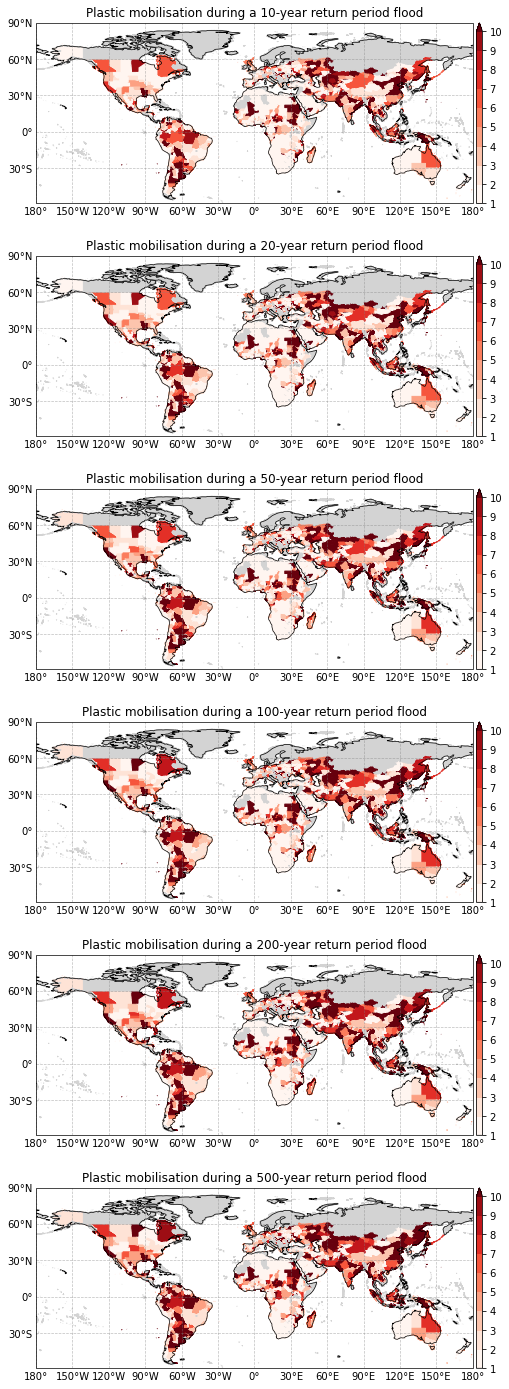

In [8]:
matplotlib.rcParams.update({'font.size': 10})
rp = (10, 20, 50, 100, 200, 500)
l = [f'e_{x}' for x in rp]
titles = [f'Plastic mobilisation during a {x}-year return period flood' for x in rp]

f, ax = plt.subplots(nrows=6, figsize=(8, 25))
ax = ax.flatten()
ax = [basemap(ax=cax, linewidth=0.7, y0=-59, fontsize=8) for cax in ax]
for i, col in enumerate(l):
    plot_shapes(df=df_flopros, values=df_flopros[l[i]] / df_flopros.e_1, cmap="Reds", bins=list(range(1, 11)),
                ax=ax[i], nan_color='lightgrey')
    plot_classified_shapes(df=df_flopros_nans, values=1, colors=['lightgrey'], ax=ax[i], legend=None)
    ax[i].set_title(titles[i], fontsize=12)
plt.savefig("figures/draft/global_admin_jump_natural_all.png", dpi=300, bbox_inches='tight')
plt.show()
matplotlib.rcParams.update({'font.size': 12})

### All return periods 'jump' masked

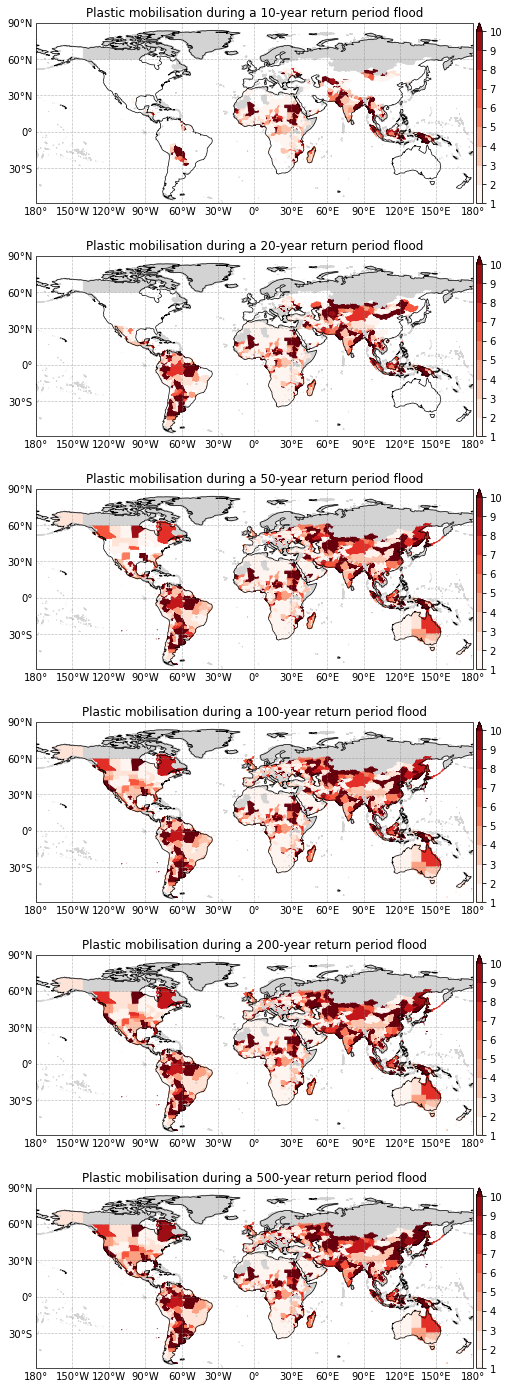

In [9]:
matplotlib.rcParams.update({'font.size': 10})
rp = (10, 20, 50, 100, 200, 500)
f, ax = plt.subplots(nrows=6, figsize=(8, 25))
ax = ax.flatten()
ax = [basemap(ax=cax, linewidth=0.7, y0=-59, fontsize=8) for cax in ax]
for i, col in enumerate(l):
    temp_df = df_flopros.loc[df_flopros.RP < rp[i]]
    plot_shapes(df=temp_df, values=temp_df[l[i]] / temp_df.e_1, cmap="Reds", bins=list(range(1, 11)),
                ax=ax[i], nan_color='lightgrey')
    plot_classified_shapes(df=df_flopros_nans, values=1, colors=['lightgrey'], ax=ax[i], legend=None)
    ax[i].set_title(titles[i], fontsize=12)
plt.savefig("figures/draft/global_admin_jump_protected_all.png", dpi=300, bbox_inches='tight')
plt.show()
matplotlib.rcParams.update({'font.size': 12})

### EAM global example

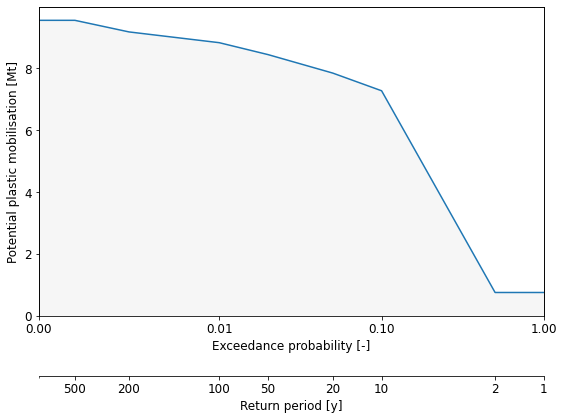

In [10]:
matplotlib.rcParams.update({'font.size': 12})
rp = [1, 1, 10, 20, 50, 100, 200, 500, 500]
p = [1 / i for i in rp]
p[1] = 0.5
p[-1] = 0

idx = [f"e_{x}" for x in rp]

f, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(p[::-1], df_world[idx[::-1]])
ax.set_xscale("symlog", linthreshx=0.01)
ax.set_xlabel("Exceedance probability [-]")
ax.set_ylim(0, None)
ax.set_xlim(0, 1)

ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')  # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Return period [y]')
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale("symlog", linthreshx=0.01)
rp[1] = 2
ax2.set_xticks(p[:-1][::-1])
ax2.set_xticklabels(rp[:-1][::-1])

ax.set_ylabel("Potential plastic mobilisation [Mt]")
ax.fill_between(p[::-1], df_world[idx[::-1]].values.tolist(), 0, facecolor="lightgrey", alpha=0.2)
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.tight_layout()
plt.savefig("figures/draft/EAM_calculation.png", dpi=300, bbox_inches='tight')
plt.show()

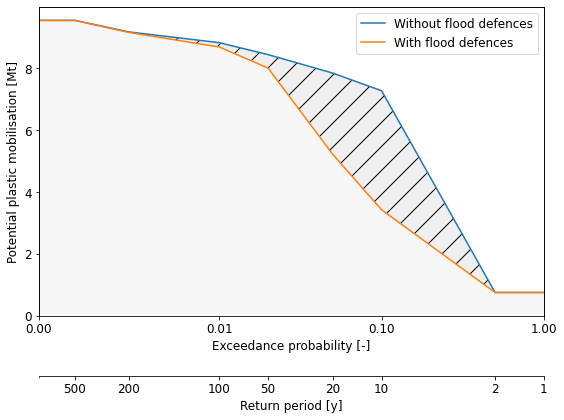

In [11]:
rp = [1, 1, 10, 20, 50, 100, 200, 500, 500]
p = [1 / i for i in rp]
p[1] = 0.5
p[-1] = 0

idx = [f"e_{x}" for x in rp]
idx_protected = [f"e_{x}_protected" for x in rp]

f, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(p[::-1], df_world[idx[::-1]], label='Without flood defences')
ax.plot(p[::-1], df_world[idx_protected[::-1]], label='With flood defences')
ax.set_xscale("symlog", linthreshx=0.01)
ax.set_xlabel("Exceedance probability [-]")
ax.set_ylim(0, None)
ax.set_xlim(0, 1)
plt.legend()

ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')  # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Return period [y]')
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale("symlog", linthreshx=0.01)
rp[1] = 2
ax2.set_xticks(p[:-1][::-1])
ax2.set_xticklabels(rp[:-1][::-1])

ax.set_ylabel("Potential plastic mobilisation [Mt]")
ax.fill_between(p[::-1], df_world[idx[::-1]].values.tolist(), 0, facecolor="lightgrey", alpha=0.2)
ax.fill_between(p[::-1], df_world[idx[::-1]].values.tolist(), df_world[idx_protected[::-1]].values.tolist(), facecolor="lightgrey", alpha=0.2, hatch='/')
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.tight_layout()
plt.savefig("figures/draft/EAM_calculation_with_protected.png", dpi=300, bbox_inches='tight')
plt.show()

### Methodology

In [13]:
basins_shp_admin1 = gpd.read_file("data/plastic_mobilisation/flopros.shp")

M_extent_1 = mp.Raster("data/River_network/global_chans_30arcs.tif")
M_water_bodies = mp.Raster("data/reprojected/water_bodies.tif")
M_extent_10 = mp.Raster("data/reprojected/extent_10.tif")
M_extent_20 = mp.Raster("data/reprojected/extent_20.tif")
M_extent_50 = mp.Raster("data/reprojected/extent_50.tif")
M_extent_100 = mp.Raster("data/reprojected/extent_100.tif")
M_extent_200 = mp.Raster("data/reprojected/extent_200.tif")
M_extent_500 = mp.Raster("data/reprojected/extent_500.tif")
M_mpw = mp.Raster("data/reprojected/mpw.tif")

ind = [81, 15, 95, 30]
extent_1 = M_extent_1[ind]
water_bodies = M_water_bodies[ind]

extent_10 = M_extent_10[ind]
extent_20 = M_extent_20[ind]
extent_50 = M_extent_50[ind]
extent_100 = M_extent_100[ind]
extent_200 = M_extent_200[ind]
extent_500 = M_extent_500[ind]
mpw = M_mpw[ind]
mpw[mpw == 0] = np.nan
mpw[mpw == -0] = np.nan

extent_1_mask = np.logical_or(extent_1 == 1, water_bodies == 1) * 1
extent_10_mask = np.logical_and(~np.isnan(extent_10), ~extent_1_mask) * 2
extent_20_mask = np.logical_and(~np.isnan(extent_20), ~extent_1_mask) * 3
extent_50_mask = np.logical_and(~np.isnan(extent_50), ~extent_1_mask) * 4
extent_100_mask = np.logical_and(~np.isnan(extent_100), ~extent_1_mask) * 5
extent_200_mask = np.logical_and(~np.isnan(extent_200), ~extent_1_mask) * 6
extent_500_mask = np.logical_and(~np.isnan(extent_500), ~extent_1_mask) * 7

combined_extents_mask = np.asarray([extent_1_mask, extent_10_mask, extent_20_mask, extent_50_mask,
                                    extent_100_mask, extent_200_mask, extent_500_mask])
combined_extents_mask[combined_extents_mask == 0] = 10
combined_extents = np.min(combined_extents_mask, axis=0).astype(float)
combined_extents[combined_extents == 10] = np.nan

/Users/jroebroek/Projects/ECWMF_plastic/geomappy/plotting.py:491: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  colors = np.array(colors)


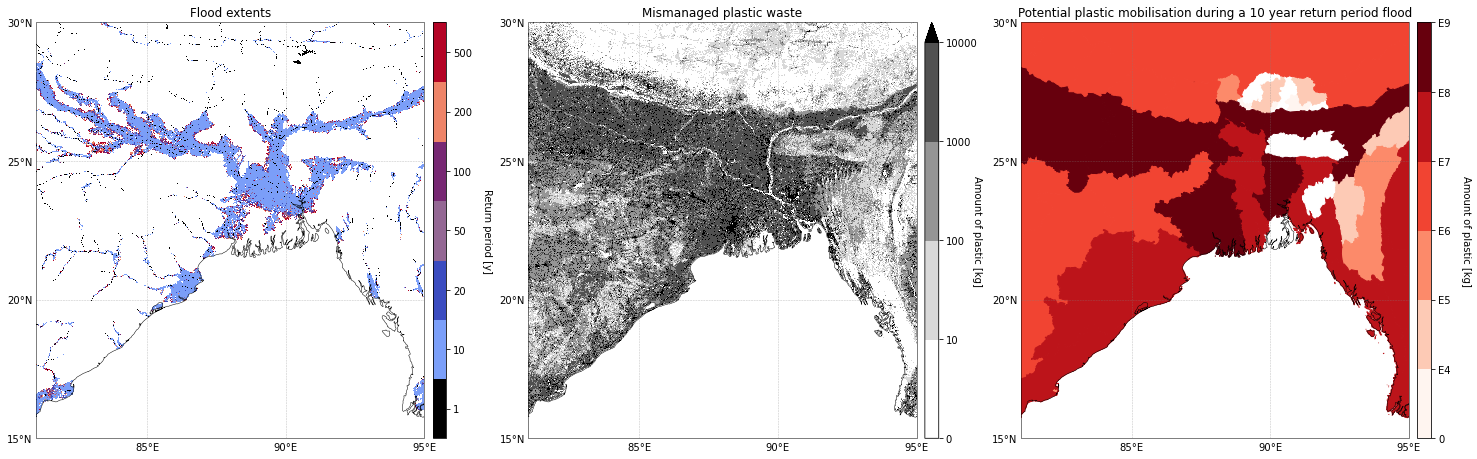

In [14]:
matplotlib.rcParams.update({'font.size': 10})
basins_shp_admin1 = gpd.read_file("data/plastic_mobilisation/flopros.shp")

M_extent_1 = mp.Raster("data/River_network/global_chans_30arcs.tif")
M_water_bodies = mp.Raster("data/reprojected/water_bodies.tif")
M_extent_10 = mp.Raster("data/reprojected/extent_10.tif")
M_extent_20 = mp.Raster("data/reprojected/extent_20.tif")
M_extent_50 = mp.Raster("data/reprojected/extent_50.tif")
M_extent_100 = mp.Raster("data/reprojected/extent_100.tif")
M_extent_200 = mp.Raster("data/reprojected/extent_200.tif")
M_extent_500 = mp.Raster("data/reprojected/extent_500.tif")
M_mpw = mp.Raster("data/reprojected/mpw.tif")

ind = [81, 15, 95, 30]
extent_1 = M_extent_1[ind]
water_bodies = M_water_bodies[ind]

extent_10 = M_extent_10[ind]
extent_20 = M_extent_20[ind]
extent_50 = M_extent_50[ind]
extent_100 = M_extent_100[ind]
extent_200 = M_extent_200[ind]
extent_500 = M_extent_500[ind]
mpw = M_mpw[ind]
mpw[mpw == 0] = np.nan
mpw[mpw == -0] = np.nan

extent_1_mask = np.logical_or(extent_1 == 1, water_bodies == 1) * 1
extent_10_mask = np.logical_and(~np.isnan(extent_10), ~extent_1_mask) * 2
extent_20_mask = np.logical_and(~np.isnan(extent_20), ~extent_1_mask) * 3
extent_50_mask = np.logical_and(~np.isnan(extent_50), ~extent_1_mask) * 4
extent_100_mask = np.logical_and(~np.isnan(extent_100), ~extent_1_mask) * 5
extent_200_mask = np.logical_and(~np.isnan(extent_200), ~extent_1_mask) * 6
extent_500_mask = np.logical_and(~np.isnan(extent_500), ~extent_1_mask) * 7

combined_extents_mask = np.asarray([extent_1_mask, extent_10_mask, extent_20_mask, extent_50_mask,
                                    extent_100_mask, extent_200_mask, extent_500_mask])
combined_extents_mask[combined_extents_mask == 0] = 10
combined_extents = np.min(combined_extents_mask, axis=0).astype(float)
combined_extents[combined_extents == 10] = np.nan

f, ax = plt.subplots(ncols=3, figsize=(25, 10))
ax = ax.flatten()
ax = [mp.basemap(x0=ind[0], x1=ind[2], y0=ind[1], y1=ind[3], linewidth=0.5, resolution="10m", xticks=5, yticks=5,
              ax=cax) for cax in ax]

colors = ['Black'] + list(cmap_discrete(n=6, cmap='coolwarm', return_type='list'))
colors = (colors[0], colors[2], colors[1], np.mean((colors[1], colors[5]), axis=0), np.mean((colors[1], colors[6]), axis=0), colors[5], colors[6])
mp.plot_classified_map(combined_extents, bins=[1, 2, 3, 4, 5, 6, 7], labels=[1, 10, 20, 50, 100, 200, 500], ax=ax[0],
                    colors=colors, legend='colorbar')

mp.plot_map(mpw, ax=ax[1], bins=[0, 10, 100, 1000, 10000], cmap='Greys')

df = basins_shp_admin1
mp.plot_shapes(df=basins_shp_admin1, values='e_10', cmap="Reds",
            bins=[0, 10000, 100000, 1000000, 10000000, 100000000, 1000000000],
            bin_labels=["0", "E4", "E5", "E6", "E7", "E8", "E9"], ax=ax[2])

ax[0].set_title("Flood extents")
ax[1].set_title("Mismanaged plastic waste")
ax[2].set_title("Potential plastic mobilisation during a 10 year return period flood")
f.axes[-3].set_ylabel('Return period [y]', rotation=270, labelpad=20)
f.axes[-2].set_ylabel("Amount of plastic [kg]", rotation=270)
f.axes[-1].set_ylabel("Amount of plastic [kg]", rotation=270, labelpad=20)
plt.savefig(f"figures/draft/methodology", dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

/Users/jroebroek/Projects/ECWMF_plastic/geomappy/plotting.py:491: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  colors = np.array(colors)


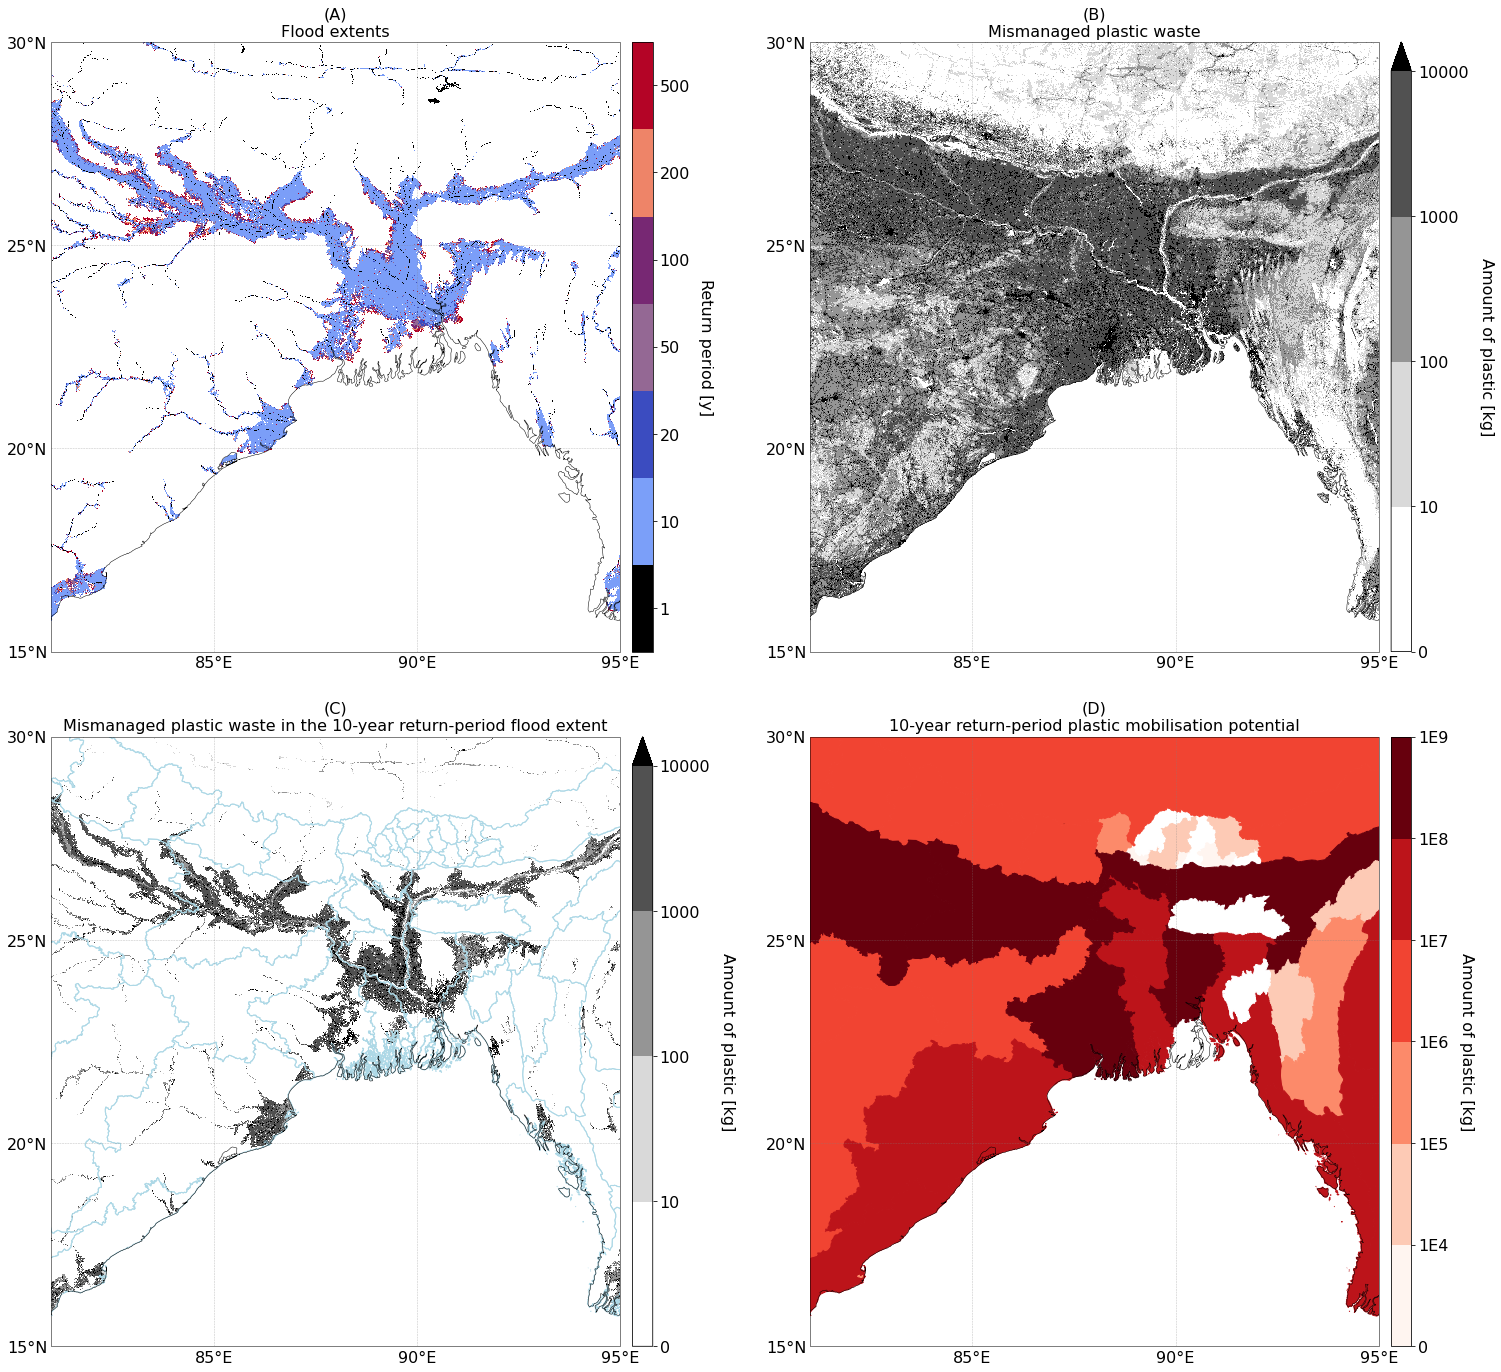

In [15]:
matplotlib.rcParams.update({'font.size': 16})
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.tight_layout(w_pad=7, h_pad=-1)
ax = ax.flatten()
ax = [mp.basemap(x0=ind[0], x1=ind[2], y0=ind[1], y1=ind[3], linewidth=0.5, resolution="10m", xticks=5, yticks=5, 
              ax=cax) for cax in ax]

colors = ['Black'] + list(cmap_discrete(n=6, cmap='coolwarm', return_type='list'))
colors = (colors[0], colors[2], colors[1], np.mean((colors[1], colors[5]), axis=0), np.mean((colors[1], colors[6]), axis=0), colors[5], colors[6])
mp.plot_classified_map(combined_extents, bins=[1, 2, 3, 4, 5, 6, 7], labels=[1, 10, 20, 50, 100, 200, 500], ax=ax[0],
                    colors=colors, legend='colorbar')

mp.plot_map(mpw, ax=ax[1], bins=[0, 10, 100, 1000, 10000], cmap='Greys')

df = basins_shp_admin1
mp.plot_shapes(df=basins_shp_admin1, values='e_10', cmap="Reds",
            bins=[0, 10000, 100000, 1000000, 10000000, 100000000, 1000000000],
            bin_labels=["0", "1E4", "1E5", "1E6", "1E7", "1E8", "1E9"], ax=ax[3])

mask = np.logical_or(extent_1_mask, extent_10_mask)
mpw_masked = mpw.copy()
mpw_masked[~mask] = np.nan
mp.plot_classified_shapes(df=basins_shp_admin1, ax=ax[2], edgecolor='lightblue', facecolor=(1,1,1,0))
mp.plot_map(mpw_masked, ax=ax[2], bins=[0, 10, 100, 1000, 10000], cmap='Greys')

ax[0].set_title("(A)\nFlood extents", fontsize=16)
ax[1].set_title("(B)\nMismanaged plastic waste", fontsize=16)
ax[2].set_title("(C)\nMismanaged plastic waste in the 10-year return-period flood extent", fontsize=16)
ax[3].set_title("(D)\n10-year return-period plastic mobilisation potential", fontsize=16)

f.axes[-4].set_ylabel('Return period [y]', rotation=270, labelpad=23)
f.axes[-3].set_ylabel("Amount of plastic [kg]", rotation=270, labelpad=25)
f.axes[-2].set_ylabel("Amount of plastic [kg]", rotation=270, labelpad=25)
f.axes[-1].set_ylabel("Amount of plastic [kg]", rotation=270, labelpad=25)

plt.savefig(f"figures/draft/methodology_extended", dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

## Tables

In [16]:
df_countries.sort_values('e_1', ascending=False).head(10).loc[:, ['Country_Name', 'Three_Letter_Country_Code', 'e_1', 'e_10', 'jump']]

,Country_Name,Three_Letter_Country_Code,e_1,e_10,jump
44,"China, People's Republic of",CHN,1.841669e+08,1.812046e+09,9.839149
105,"India, Republic of",IND,1.191535e+08,1.363945e+09,11.446953
33,"Brazil, Federative Republic of",BRA,3.903849e+07,1.214705e+08,3.111557
219,"Thailand, Kingdom of",THA,3.165274e+07,4.746465e+08,14.995431
67,"Egypt, Arab Republic of",EGY,2.531575e+07,5.473263e+08,21.619989
177,"Philippines, Republic of the",PHL,2.482364e+07,1.099197e+08,4.428026
227,"Turkey, Republic of",TUR,1.763727e+07,5.424713e+07,3.075710
47,"Congo, Democratic Republic of the",COD,1.724126e+07,3.723768e+07,2.159801
164,"Nigeria, Federal Republic of",NGA,1.674430e+07,1.083694e+08,6.472015
242,"Vietnam, Socialist Republic of",VNM,1.660059e+07,4.355871e+08,26.239250


In [17]:
df_countries.sort_values('e_1', ascending=False).tail(10).loc[:, ['Country_Name', 'Three_Letter_Country_Code', 'e_1', 'e_10', 'jump']]

,Country_Name,Three_Letter_Country_Code,e_1,e_10,jump
107,Ireland,IRL,10186.430000,30042.620000,2.949279
53,"Costa Rica, Republic of",CRI,7911.502619,26973.367804,3.409386
69,Western Sahara,ESH,7305.081200,7305.081200,1.000000
10,"Armenia, Republic of",ARM,6869.302150,17568.513270,2.557540
172,"Oman, Sultanate of",OMN,5266.790000,14486.220000,2.750484
203,"Somalia, Somali Republic",SOM,4188.708600,4531.361600,1.081804
174,"Panama, Republic of",PAN,3530.143070,25401.388840,7.195569
111,"Israel, State of",ISR,2505.933800,2994.733800,1.195057
215,Syrian Arab Republic,SYR,471.009800,471.009800,1.000000
8,United Arab Emirates,ARE,47.440000,51.860000,1.093170


In [18]:
df_flopros.sort_values('jump', ascending=False).head(10).loc[:, ['NAME_1', 'NAME_0', 'ISO', 'e_1', 'e_10', 'jump']]

,NAME_1,NAME_0,ISO,e_1,e_10,jump
3493,Báº¿n Tre,Vietnam,VNM,98.05480,1.031823e+07,105229.179675
1004,Lower River,Gambia,GMB,4.89165,1.262998e+05,25819.460530
3546,Tiá»n Giang,Vietnam,VNM,883.25390,1.932245e+07,21876.441376
828,Al Qalyubiyah,Egypt,EGY,2008.79900,3.152832e+07,15695.110119
816,Ad Daqahliyah,Egypt,EGY,1699.52500,1.381653e+07,8129.643008
3549,VÄ©nh Long,Vietnam,VNM,2991.05280,1.266085e+07,4232.906202
3539,SÃ³c TrÄ?ng,Vietnam,VNM,3914.59050,1.551268e+07,3962.785611
2872,Wanica,Suriname,SUR,2340.05160,3.259850e+06,1393.067765
986,Greater Accra,Ghana,GHA,598.45254,6.319347e+05,1055.947966
1767,Glodeni,Moldova,MDA,56.48697,3.980256e+04,704.632580


## Export data

In [19]:
df_flopros.columns

Index(['OBJECTID', 'ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'HASC_1',
       'CCN_1', 'CCA_1', 'TYPE_1', 'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1',
       'Shape_Leng', 'Shape_Area', 'sam_objID', 'sam_code', 'FID_1',
       'FID_Aque', 'e_1', 'e_10', 'e_20', 'e_50', 'e_100', 'e_200', 'e_500',
       'area_1', 'area_10', 'jump', 'geometry', 'RP', 'e_1_protected',
       'e_10_protected', 'e_20_protected', 'e_50_protected', 'e_100_protected',
       'e_200_protected', 'e_500_protected', 'EAM', 'EAM_protected'],
      dtype='object')

In [20]:
rp = [1,10,20,50,100,200,500]
df_flopros.loc[:, ['ISO', 'NAME_0', 'NAME_1', 'TYPE_1', 'ENGTYPE_1'] + \
               [f"e_{x}" for x in rp] + \
               [f"e_{x}_protected" for x in rp] + \
               ['EAM', 'EAM_protected', 'RP', 'geometry']].to_file("data/Export/data.geojson", driver='GeoJSON')